# Capstone Project
### Group 3
#### Solmaz Haider Nassab
#### Huiquio Feng
#### Nadimul Hasan



# Breast Cancer Prediction: Image Segmentation and Classification with Deep Learning

In [ ]:
!pip install vit_keras
!pip install tensorflow_addons
!pip install 'keras<3.0.0' mediapipe-model-makerb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 10.8 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.2
    Uninstalling typeguard-4.4.2:
      Successfully uninstalled typeguard-4.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.
ERROR: Could not find a version that satisfies the requirement mediapipe-model-makerb (from versions: none)
ERROR: No matching distribution found for mediapipe-model-makerb


In [ ]:
# Import the required libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import EfficientNetB3
import seaborn as sns
import cv2
from tqdm import tqdm

In [ ]:
# Load images and masks
def load_images_and_masks(path, img_size=(224, 224)):
    images = []
    masks = []
    labels = []

    for category in ['benign', 'malignant', 'normal']:
        category_path = os.path.join(path, category)
        for file_name in os.listdir(category_path):
            if 'mask' not in file_name:  # Exclude masks from image loading
                image_path = os.path.join(category_path, file_name)
                mask_path = image_path.replace('.png', '_mask.png')

                image = load_img(image_path, target_size=img_size)
                mask = load_img(mask_path, target_size=img_size, color_mode="grayscale")

                image = img_to_array(image) / 255.0  # Normalize image
                mask = img_to_array(mask) / 255.0  # Normalize mask (binary)

                images.append(image)
                masks.append(mask)

                # Assign labels (0: normal, 1: benign, 2: malignant)
                if category == 'normal':
                    labels.append(0)
                elif category == 'benign':
                    labels.append(1)
                else:
                    labels.append(2)

    return np.array(images), np.array(masks), np.array(labels)

In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load data
dataset_path = '/content/drive/MyDrive/Dataset_BUSI_with_GT/'
img_size = (224, 224)  # Resized image size for model input
images, masks, labels = load_images_and_masks(dataset_path, img_size=img_size)

In [ ]:
print("Images shape:", images.shape)
print("Masks shape:", masks.shape)
print("Labels shape:", labels.shape)

Images shape: (780, 224, 224, 3)
Masks shape: (780, 224, 224, 1)
Labels shape: (780,)


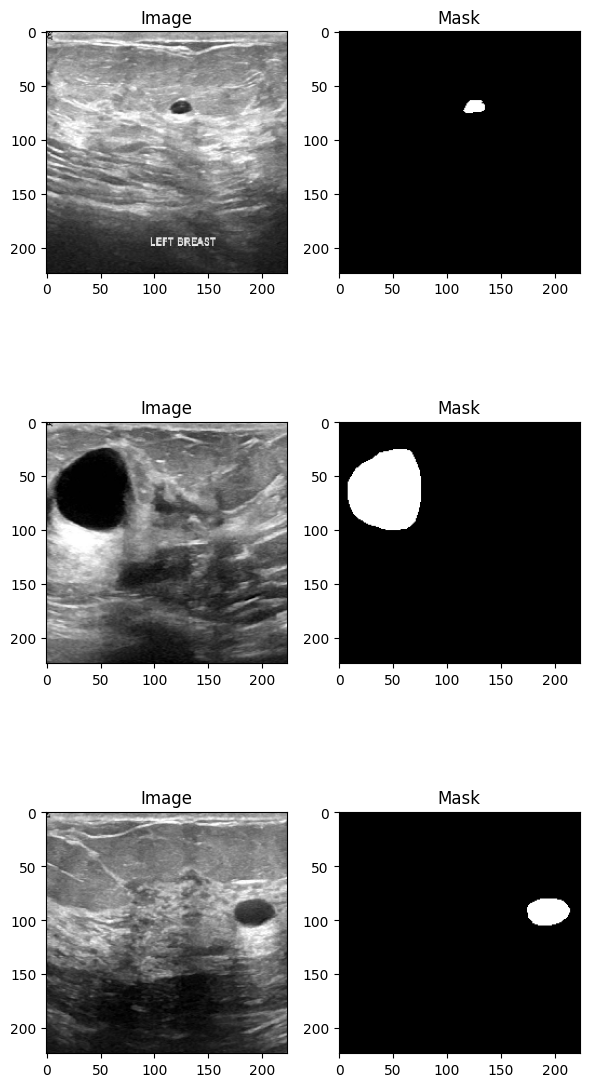

In [ ]:
# Visualize sample images along with their corresponding masks
num_samples = 3

fig, axes = plt.subplots(num_samples, 2, figsize=(6, 12))

for i in range(num_samples):
    axes[i, 0].imshow(images[i])
    axes[i, 0].axis('on')
    axes[i, 0].set_title('Image')

    axes[i, 1].imshow(masks[i], cmap='gray')
    axes[i, 1].axis('on')
    axes[i, 1].set_title('Mask')

plt.tight_layout()
plt.show()

# Data Augmentation

In [ ]:
# Count occurrences of each label
unique_labels, counts = np.unique(labels, return_counts=True)

# Labels (0: normal, 1: benign, 2: malignant)
for label, count in zip(unique_labels, counts):
    print(f"Label {label}: {count} occurrences")

Label 0: 133 occurrences
Label 1: 437 occurrences
Label 2: 210 occurrences


In [ ]:
# Seperate images for augmentation
normal_malignant = images[(labels == 0) | (labels == 2)]
normal_malignant_masks = masks[(labels == 0) | (labels == 2)]
normal_malignant_labels = labels[(labels == 0) | (labels == 2)]
print(normal_malignant.shape)
print(normal_malignant_masks.shape)
print(normal_malignant_labels.shape)

(343, 224, 224, 3)
(343, 224, 224, 1)
(343,)


In [ ]:
# Define augmentation settings
datagen = ImageDataGenerator(
    rotation_range=15,
    shear_range=0.1,
    horizontal_flip=True,
)

# Create the generator to flow images and masks together
image_generator = datagen.flow(normal_malignant, batch_size=1, seed=42)
mask_generator = datagen.flow(normal_malignant_masks, batch_size=1, seed=42)

def combine_generators(image_gen, mask_gen):
    while True:
        img = image_gen.__next__()
        mask = mask_gen.__next__()
        yield (img[0], mask[0])  # Yield as tuples of (image, mask)

combined_gen = combine_generators(image_generator, mask_generator)


# Empty lists to store augmented images and masks
augmented_images_list = []
augmented_masks_list = []

# Save augmented images and corresponding masks
for i in range(len(normal_malignant)):
    aug_img, aug_mask = next(combined_gen)

    augmented_images_list.append(aug_img)
    augmented_masks_list.append(aug_mask)


# Convert lists to NumPy arrays
augmented_images_array = np.array(augmented_images_list)
augmented_masks_array = np.array(augmented_masks_list)

# Concatenate with the original dataset
images_updated = np.concatenate((images, augmented_images_array), axis=0)
masks_updated = np.concatenate((masks, augmented_masks_array), axis=0)
labels_updated = np.concatenate((labels, normal_malignant_labels), axis=0)


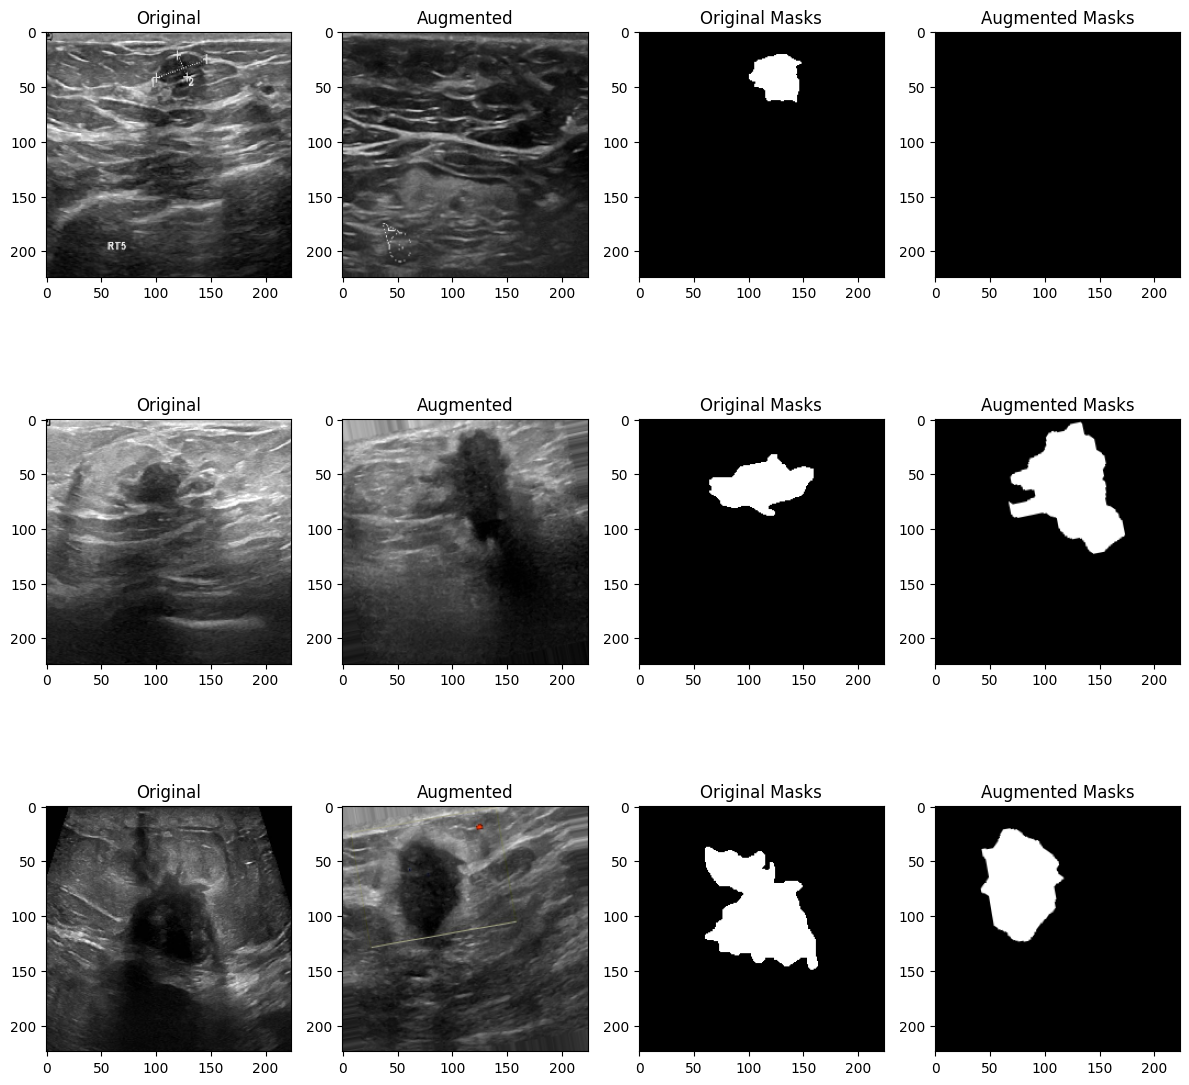

In [ ]:
# Visualize sample images along with their corresponding augmented images
num_samples = 3

fig, axes = plt.subplots(num_samples, 4, figsize=(12, 12))

for i in range(num_samples):
    axes[i, 0].imshow(normal_malignant[i])
    axes[i, 0].axis('on')
    axes[i, 0].set_title('Original')

    axes[i, 1].imshow(augmented_images_array[i])
    axes[i, 1].axis('on')
    axes[i, 1].set_title('Augmented')

    axes[i, 2].imshow(normal_malignant_masks[i], cmap = 'gray')
    axes[i, 2].axis('on')
    axes[i, 2].set_title('Original Masks')

    axes[i, 3].imshow(augmented_masks_array[i], cmap = 'gray')
    axes[i, 3].axis('on')
    axes[i, 3].set_title('Augmented Masks')

plt.tight_layout()
plt.show()

In [ ]:
print("Images shape:", images_updated.shape)
print("Masks shape:", masks_updated.shape)
print("Labels shape:", labels_updated.shape)

# Count occurrences of each label
unique_labels, counts = np.unique(labels_updated, return_counts=True)

# Labels (0: normal, 1: benign, 2: malignant)
for label, count in zip(unique_labels, counts):
    print(f"Label {label}: {count} occurrences")

Images shape: (1123, 224, 224, 3)
Masks shape: (1123, 224, 224, 1)
Labels shape: (1123,)
Label 0: 266 occurrences
Label 1: 437 occurrences
Label 2: 420 occurrences


# EfficientNetB3 Model for Classification
EfficientNetB3 is a convolutional neural network (CNN) model selected for its computational efficiency and strong performance on image classification tasks, particularly for smaller-scale medical images like ultrasounds. It is trained and evaluated on original, non-segmented images, which helps establish a baseline for comparison, enabling us to understand the impact of segmentation on classification performance.

In [ ]:
# One-hot encode the labels
labels_encoded = to_categorical(labels_updated, num_classes=3)

# Split into train, validation, and test sets (70% train, 10% val, 10% test)
X_train, X_temp, y_train, y_temp, mask_train, mask_temp = train_test_split(images_updated, labels_encoded, masks_updated, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test, mask_val, mask_test = train_test_split(X_temp, y_temp, mask_temp, test_size=0.5, random_state=42)

print("Training set shape:", X_train.shape, mask_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, mask_val.shape, y_val.shape)
print("Testing set shape:", X_test.shape, mask_test.shape, y_test.shape)

Training set shape: (786, 224, 224, 3) (786, 224, 224, 1) (786, 3)
Validation set shape: (168, 224, 224, 3) (168, 224, 224, 1) (168, 3)
Testing set shape: (169, 224, 224, 3) (169, 224, 224, 1) (169, 3)


In [ ]:
# Load the pre-trained EfficientNetB3 model
base_model = EfficientNetB3(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze the base model layers
base_model.trainable = False

# Build the model
cnn_model = tf.keras.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.7),
    layers.Dense(3, activation='softmax')  # 3 classes: normal, benign, malignant
])

# Compile the model
cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(), #learning_rate=lr_schedule),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define an EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
#class_weights_dict = {0: 1.2, 1: 0.86, 2: 0.9}
# Train the model
history = cnn_model.fit(
    X_train, y_train,
    #class_weight=class_weights_dict,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=128,
    callbacks=[early_stopping]
)

Epoch 1/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 86s 7s/step - accuracy: 0.3267 - loss: 38.7905 - val_accuracy: 0.2321 - val_loss: 14.4109
Epoch 2/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 375ms/step - accuracy: 0.3426 - loss: 17.1747 - val_accuracy: 0.3690 - val_loss: 5.8828
Epoch 3/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 281ms/step - accuracy: 0.3455 - loss: 6.7925 - val_accuracy: 0.3690 - val_loss: 6.0537
Epoch 4/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 325ms/step - accuracy: 0.3909 - loss: 6.2146 - val_accuracy: 0.3690 - val_loss: 5.2411
Epoch 5/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 325ms/step - accuracy: 0.3652 - loss: 5.1595 - val_accuracy: 0.3690 - val_loss: 4.8587


In [ ]:
# Evaluate the model on the original test set
test_loss, test_acc = cnn_model.evaluate(X_test, y_test)
print(f"EfficientNetB3 Test Accuracy: {test_acc * 100:.2f}%, Test Loss: {test_loss:.2f}")

# Make predictions on the original test set
y_pred = cnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification Report
report = classification_report(y_true_classes, y_pred_classes, target_names=['Normal', 'Benign', 'Malignant'])
print("Classification Report:\n", report)

6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.3814 - loss: 4.8583
EfficientNetB3 Test Accuracy: 36.69%, Test Loss: 4.86
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step
Classification Report:
               precision    recall  f1-score   support

      Normal       0.00      0.00      0.00        36
      Benign       0.00      0.00      0.00        71
   Malignant       0.37      1.00      0.54        62

    accuracy                           0.37       169
   macro avg       0.12      0.33      0.18       169
weighted avg       0.13      0.37      0.20       169



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


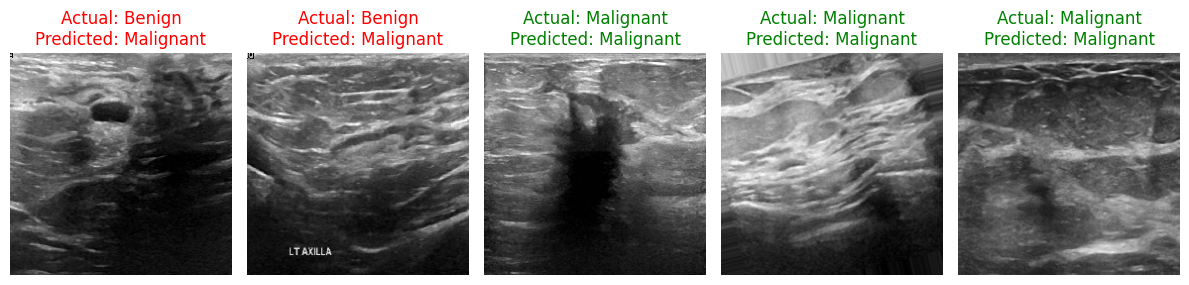

In [ ]:
# Number of samples to display
num_samples = 5

# Select random images from the test set
indices = np.random.choice(len(X_test), num_samples, replace=False)
sample_images = X_test[indices]
sample_labels = y_test[indices]

# Predict the labels for the sample images
predictions = cnn_model.predict(sample_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(sample_labels, axis=1)

# Label names
class_names = ['Normal', 'Benign', 'Malignant']

# Plot the sample images with actual and predicted labels
plt.figure(figsize=(12, 6))
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(sample_images[i])
    actual_class = class_names[true_labels[i]]
    predicted_class = class_names[predicted_labels[i]]
    color = "green" if predicted_class == actual_class else "red"
    plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}", color=color)
    plt.axis("off")

plt.tight_layout()
plt.show()

## 3. Image Segmentation
Accurate segmentation of regions suspected to contain tumors enhances classification focus by isolating the regions of interest. This step will also allow us to compare classification performance between images with and without highlighted regions of interest.

### 3.1. Overlaying Images with Masks
To highlight regions of interest, original images are overlaid with their corresponding masks.

In [ ]:
# A function to overlay images with their corresponding masks
def overlay_images_with_masks(images, masks):
    overlaid_images = []
    for image, mask in zip(images, masks):
        colored_mask = np.zeros_like(image)
        colored_mask[..., 0] = mask[..., 0] * 255  # Red channel
        overlay = cv2.addWeighted(image, 0.6, colored_mask, 0.4, 0)
        overlaid_images.append(overlay)
    return np.array(overlaid_images)

In [ ]:
# A function to display a few samples of the original images along with their masks and overlaid versions
def plot_sample_overlaid_images(original_images, masks, overlaid_images, n=3):
    plt.figure(figsize=(12, 8))
    for i in range(n):
        plt.subplot(n, 3, i * 3 + 1)
        plt.imshow(original_images[i])
        plt.title("Original Image")

        plt.subplot(n, 3, i * 3 + 2)
        plt.imshow(masks[i], cmap='gray')
        plt.title("Mask")

        plt.subplot(n, 3, i * 3 + 3)
        plt.imshow(overlaid_images[i])
        plt.title("Overlaid Image")
    plt.tight_layout()
    plt.show()

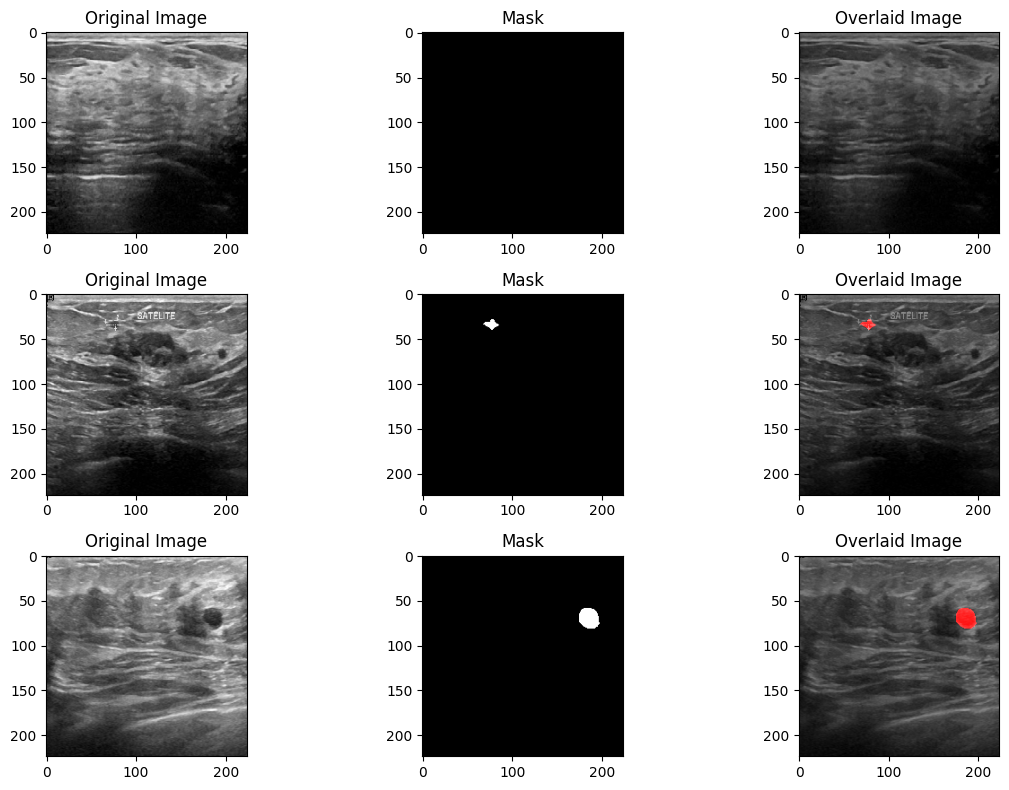

In [ ]:
# Create overlaid images for the training set
X_train_overlaid = overlay_images_with_masks(X_train, mask_train)

# Plot some sample training images
plot_sample_overlaid_images(X_train, mask_train, X_train_overlaid)

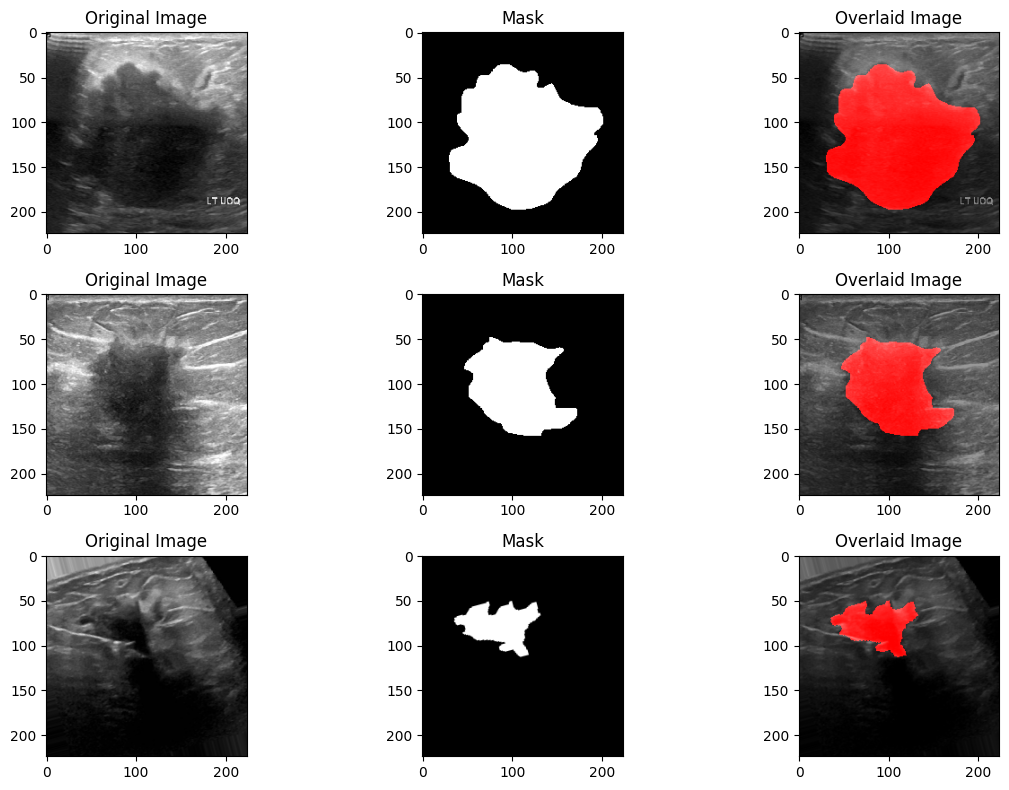

In [ ]:
# Create overlaid images for the testing set
X_test_overlaid = overlay_images_with_masks(X_test, mask_test)

# Plot some sample testing images
plot_sample_overlaid_images(X_test, mask_test, X_test_overlaid)

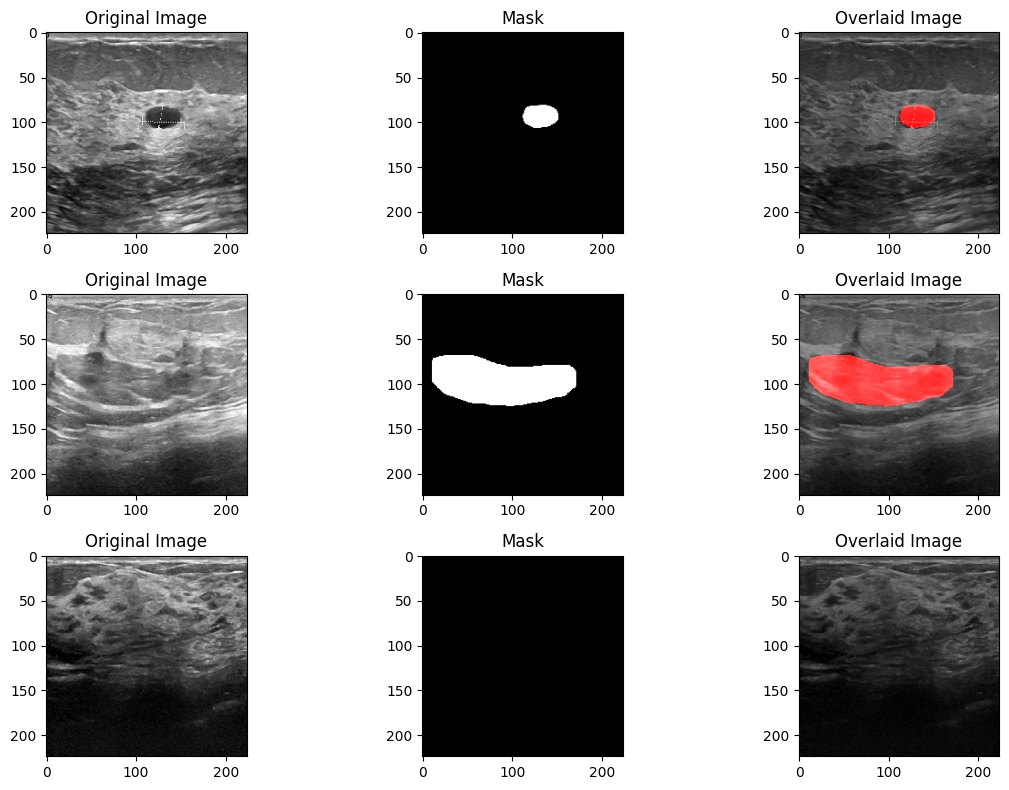

In [ ]:
# Create overlaid images for the validation set
X_val_overlaid = overlay_images_with_masks(X_val, mask_val)

# Plot some sample validation images
plot_sample_overlaid_images(X_val, mask_val, X_val_overlaid)

### 3.2. Segmentation with UNet Model
UNet is a widely used model for biomedical image segmentation. It was trained to generate segmentation masks that outline the regions of interest (potential tumors) within the ultrasound images. Its architecture features a contracting path to capture image context and an expansive path to accurately localize the segmented regions. By training on labeled masks, the UNet model learns to detect and delineate potential tumor regions.

In [ ]:
# Define the UNet model architecture
def unet_model(input_size=(224, 224, 3)):
    inputs = keras.Input(input_size)

    conv1 = layers.Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(inputs)
    conv1 = layers.Dropout(0.4)(conv1)
    conv1 = layers.Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)

    conv2 = layers.Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(pool1)
    conv2 = layers.Dropout(0.4)(conv2)
    conv2 = layers.Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)

    conv3 = layers.Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(pool2)
    conv3 = layers.Dropout(0.5)(conv3)
    conv3 = layers.Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv3)
    pool3 = layers.MaxPooling2D((2, 2))(conv3)

    conv4 = layers.Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(pool3)
    conv4 = layers.Dropout(0.5)(conv4)
    conv4 = layers.Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = layers.Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(pool4)
    conv5 = layers.Dropout(0.6)(conv5)
    conv5 = layers.Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv5)

    upconv6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv5)
    upconv6 = layers.concatenate([upconv6, conv4])
    conv6 = layers.Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(upconv6)
    conv6 = layers.Dropout(0.5)(conv6)
    conv6 = layers.Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv6)

    upconv7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6)
    upconv7 = layers.concatenate([upconv7, conv3])
    conv7 = layers.Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(upconv7)
    conv7 = layers.Dropout(0.5)(conv7)
    conv7 = layers.Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv7)

    upconv8 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv7)
    upconv8 = layers.concatenate([upconv8, conv2])
    conv8 = layers.Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(upconv8)
    conv8 = layers.Dropout(0.4)(conv8)
    conv8 = layers.Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv8)

    upconv9 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv8)
    upconv9 = layers.concatenate([upconv9, conv1], axis=3)
    conv9 = layers.Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(upconv9)
    conv9 = layers.Dropout(0.4)(conv9)
    conv9 = layers.Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
# Model initiation and training setup
unet = unet_model()
unet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the UNet model
history_unet = unet.fit(
    X_train, mask_train,
    validation_data=(X_val, mask_val),
    epochs=50,
    batch_size=32
    )

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.8306 - loss: 0.4188 - val_accuracy: 0.9023 - val_loss: 0.3106
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 37s 242ms/step - accuracy: 0.9216 - loss: 0.2540 - val_accuracy: 0.9133 - val_loss: 0.2860
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 245ms/step - accuracy: 0.9204 - loss: 0.2271 - val_accuracy: 0.9163 - val_loss: 0.2343
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 247ms/step - accuracy: 0.9274 - loss: 0.2090 - val_accuracy: 0.7575 - val_loss: 0.5265
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 237ms/step - accuracy: 0.9227 - loss: 0.2127 - val_accuracy: 0.7611 - val_loss: 0.5000
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 246ms/step - accuracy: 0.9259 - loss: 0.2017 - val_accuracy: 0.9160 - val_loss: 0.3414
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 246ms/step - accuracy: 0.9337 - loss: 0.1883 - val_accuracy: 0.9053 - val_loss: 0.2348
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 242ms/step - accuracy: 0.9335 - loss: 0.1836 - val_accuracy:

In [ ]:
# Evaluate the UNet model on the test set
test_loss, test_acc = unet.evaluate(X_test, mask_test)
print(f"UNet Segmentation Test Accuracy: {test_acc * 100:.2f}%, Test Loss: {test_loss:.2f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 614ms/step - accuracy: 0.9578 - loss: 0.1258
UNet Segmentation Test Accuracy: 95.81%, Test Loss: 0.13


In [ ]:
# Generate masks for the test images using UNet
mask_test_generated = unet.predict(X_test)

# Threshold the masks to create binary outputs
mask_test_generated = (mask_test_generated > 0.5).astype(np.float32)  # Convert to binary masks

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step


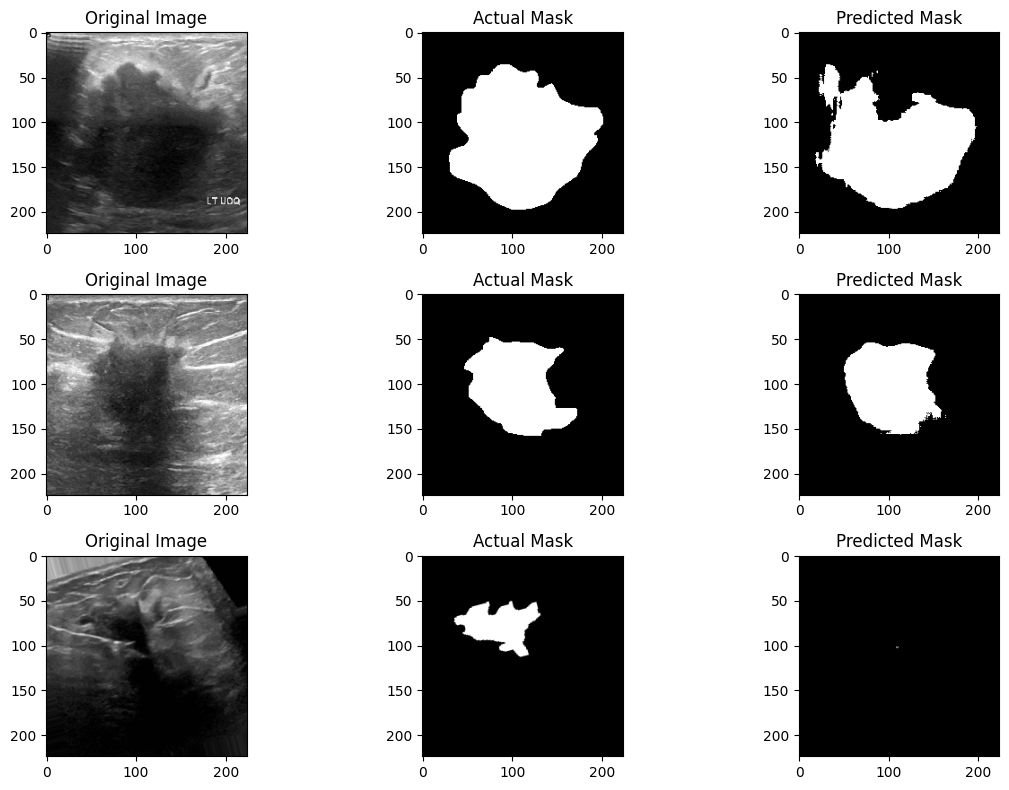

In [ ]:
# A function to display sample images along with their actual and predicted masks
def plot_sample_masks(original_images, actual_masks, predicted_masks, n=3):
    plt.figure(figsize=(12, 8))
    for i in range(n):
        plt.subplot(n, 3, i * 3 + 1)
        plt.imshow(original_images[i])
        plt.title("Original Image")

        plt.subplot(n, 3, i * 3 + 2)
        plt.imshow(actual_masks[i], cmap='gray')
        plt.title("Actual Mask")

        plt.subplot(n, 3, i * 3 + 3)
        plt.imshow(predicted_masks[i], cmap='gray')
        plt.title("Predicted Mask")
    plt.tight_layout()
    plt.show()

# Plot sample test images
plot_sample_masks(X_test, mask_test, mask_test_generated)

In [ ]:
# Create overlaid images for the testing set using the UNet-generated masks
X_test_UNet_overlaid = overlay_images_with_masks(X_test, mask_test_generated)

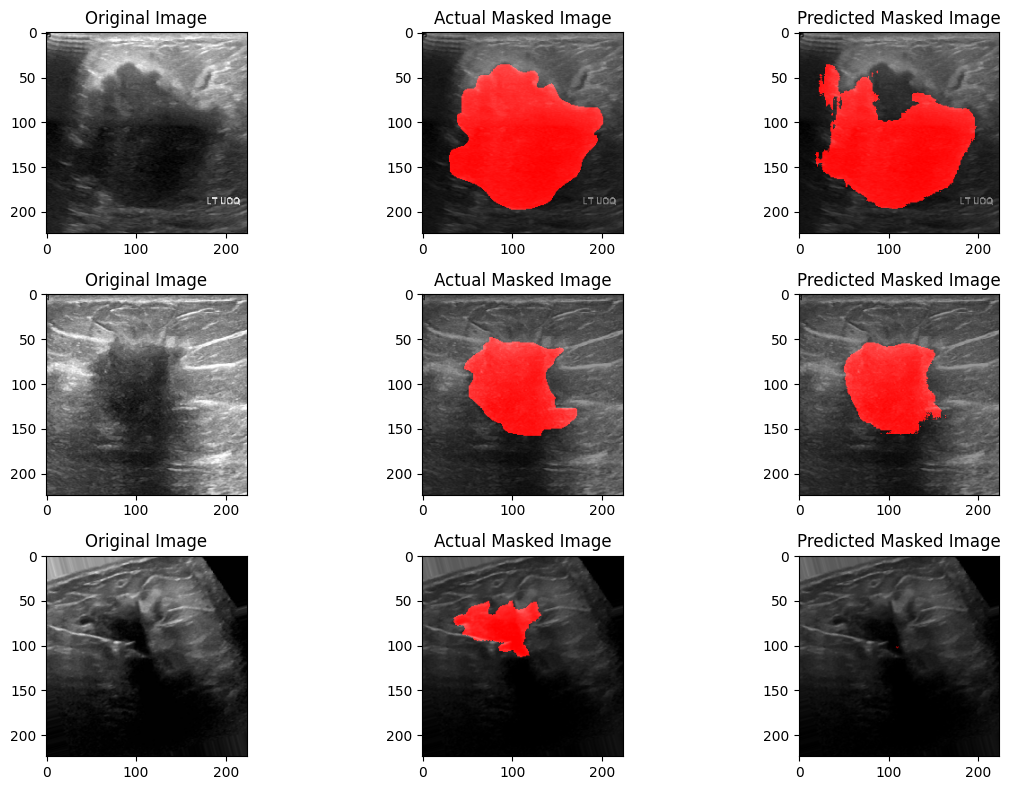

In [ ]:
# A function to display a few samples of the original images along with their overlaid versions
def plot_sample_overlaid_images(original_images, actual_overlaid, unet_overlaid, n=3):
    plt.figure(figsize=(12, 8))
    for i in range(n):
        plt.subplot(n, 3, i * 3 + 1)
        plt.imshow(original_images[i])
        plt.title("Original Image")

        plt.subplot(n, 3, i * 3 + 2)
        plt.imshow(actual_overlaid[i])
        plt.title("Actual Masked Image")

        plt.subplot(n, 3, i * 3 + 3)
        plt.imshow(unet_overlaid[i])
        plt.title("Predicted Masked Image")
    plt.tight_layout()
    plt.show()

# Plot some sample testing images
plot_sample_overlaid_images(X_test, X_test_overlaid, X_test_UNet_overlaid)

## 4. EfficientNetB3 for Classification (Segmented Images)
EfficientNetB3 is retrained using images segmented by ground truth masks and evaluated on both actual and UNet-generated masks to understand the effect of segmentation quality on classification performance. This approach leverages the segmented regions, potentially enhancing classification accuracy by focusing on the regions of interest.

In [ ]:
# Build the model
cnn_model_seg = tf.keras.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.7),
    layers.Dense(3, activation='softmax')  # 3 classes: normal, benign, malignant
])

# Compile the model
cnn_model_seg.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']

)

# Train the model
history_seg = cnn_model_seg.fit(
    X_train_overlaid, y_train,
    validation_data=(X_val_overlaid, y_val),
    epochs=20,
    batch_size=16,
    callbacks=[early_stopping]
)

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 73s 736ms/step - accuracy: 0.6092 - loss: 21.7133 - val_accuracy: 0.8036 - val_loss: 7.6241
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.7101 - loss: 7.3718 - val_accuracy: 0.8095 - val_loss: 3.9080
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.7418 - loss: 3.8549 - val_accuracy: 0.8155 - val_loss: 2.7492
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.7111 - loss: 2.8357 - val_accuracy: 0.7560 - val_loss: 2.2533
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.7212 - loss: 2.4412 - val_accuracy: 0.7798 - val_loss: 2.0969
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.7003 - loss: 2.3596 - val_accuracy: 0.8214 - val_loss: 1.6579
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.7041 - loss: 2.0253 - val_accuracy: 0.7381 - val_loss: 1.8772
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.6874 - loss: 2.0292 - val_accuracy: 0.8155 

In [ ]:
# Evaluate the EfficientNetB3 model on the masked test set
test_loss, test_acc = cnn_model_seg.evaluate(X_test_overlaid, y_test)
print(f"EfficientNetB3 Test Accuracy: {test_acc * 100:.2f}%, Test Loss: {test_loss:.2f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8819 - loss: 0.8007
EfficientNetB3 Test Accuracy: 86.39%, Test Loss: 0.79


In [ ]:
# Make predictions on the masked test set
y_pred = cnn_model_seg.predict(X_test_overlaid)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification Report
report = classification_report(y_true_classes, y_pred_classes, target_names=['Normal', 'Benign', 'Malignant'])
print("Classification Report:\n", report)

6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step
Classification Report:
               precision    recall  f1-score   support

      Normal       0.71      0.83      0.77        36
      Benign       0.93      1.00      0.97        71
   Malignant       0.88      0.73      0.80        62

    accuracy                           0.86       169
   macro avg       0.84      0.85      0.84       169
weighted avg       0.87      0.86      0.86       169



1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


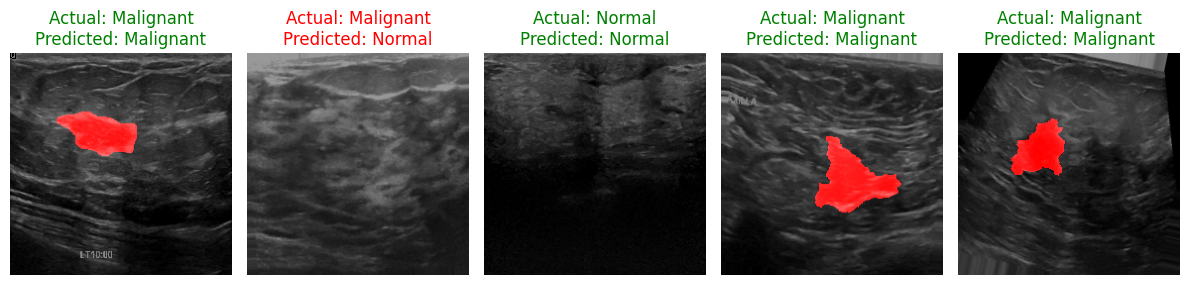

In [ ]:
# number of samples to display
num_samples = 5

# Select random images from the test set
indices = np.random.choice(len(X_test_overlaid), num_samples, replace=False)
sample_images = X_test_overlaid[indices]
sample_labels = y_test[indices]

# Predict the labels for the sample images
predictions = cnn_model_seg.predict(sample_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(sample_labels, axis=1)

# Label names
class_names = ['Normal', 'Benign', 'Malignant']

# Plot the sample images with actual and predicted labels
plt.figure(figsize=(12, 6))
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(sample_images[i])
    actual_class = class_names[true_labels[i]]
    predicted_class = class_names[predicted_labels[i]]
    color = "green" if predicted_class == actual_class else "red"
    plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}", color=color)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
cnn_model_seg.save("/content/drive/MyDrive/model.keras", save_format="keras")